Device: cuda

  AVENUE ANOMALY DETECTION - VECTORIZED
  I3D + Simple Autoencoder + Proper Normalization
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 MB 54.2 MB/s eta 0:00:00

  TRAINING (Vectorized)

Extracting features: train (stride=2)
Loading I3D model...


Downloading: "https://github.com/facebookresearch/pytorchvideo/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/pytorchvideo/model_zoo/kinetics/I3D_8x8_R50.pyth" to /root/.cache/torch/hub/checkpoints/I3D_8x8_R50.pyth
100%|██████████| 214M/214M [00:00<00:00, 355MB/s] 


Found 16 videos
Total clips: 4486


Extracting I3D:   0%|          | 0/1122 [00:00<?, ?it/s]

Feature stats after normalization: mean=0.0000, std=0.9999

Training samples: 4486
Model compiled with torch.compile()
Parameters: 5,385,344

Training for 100 epochs...
Epoch   1/100 | Loss: 0.867453 | LR: 5.00e-04
Epoch  10/100 | Loss: 0.371616 | LR: 4.88e-04
Epoch  20/100 | Loss: 0.300333 | LR: 4.52e-04
Epoch  30/100 | Loss: 0.268755 | LR: 3.97e-04
Epoch  40/100 | Loss: 0.251366 | LR: 3.28e-04
Epoch  50/100 | Loss: 0.239334 | LR: 2.51e-04
Epoch  60/100 | Loss: 0.230028 | LR: 1.73e-04
Epoch  70/100 | Loss: 0.225459 | LR: 1.04e-04
Epoch  80/100 | Loss: 0.221190 | LR: 4.87e-05
Epoch  90/100 | Loss: 0.219750 | LR: 1.32e-05
Epoch 100/100 | Loss: 0.219561 | LR: 1.00e-06

Best loss: 0.217961

  EVALUATION (Vectorized)

Extracting test features (stride=1)
Found 21 videos
Total clips: 11391


Extracting I3D (fast):   0%|          | 0/1424 [00:00<?, ?it/s]


[CORRUPTION CORRECTION STATS]
  Total frames processed: 182256
  Inverted images fixed: 163634 (89.8%)
  Noisy images fixed: 182256 (100.0%)

Feature stats: mean=0.7599, std=3.0278

Test clips: 11391
Computing reconstruction errors...


Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]

Aggregating frame scores...

Results:
  Frames: 11706
  Score range: [0.0000, 1.0000]
  Threshold: 0.4764
  Anomalies: 630 (5.4%)

Saved: avenue_scores.csv


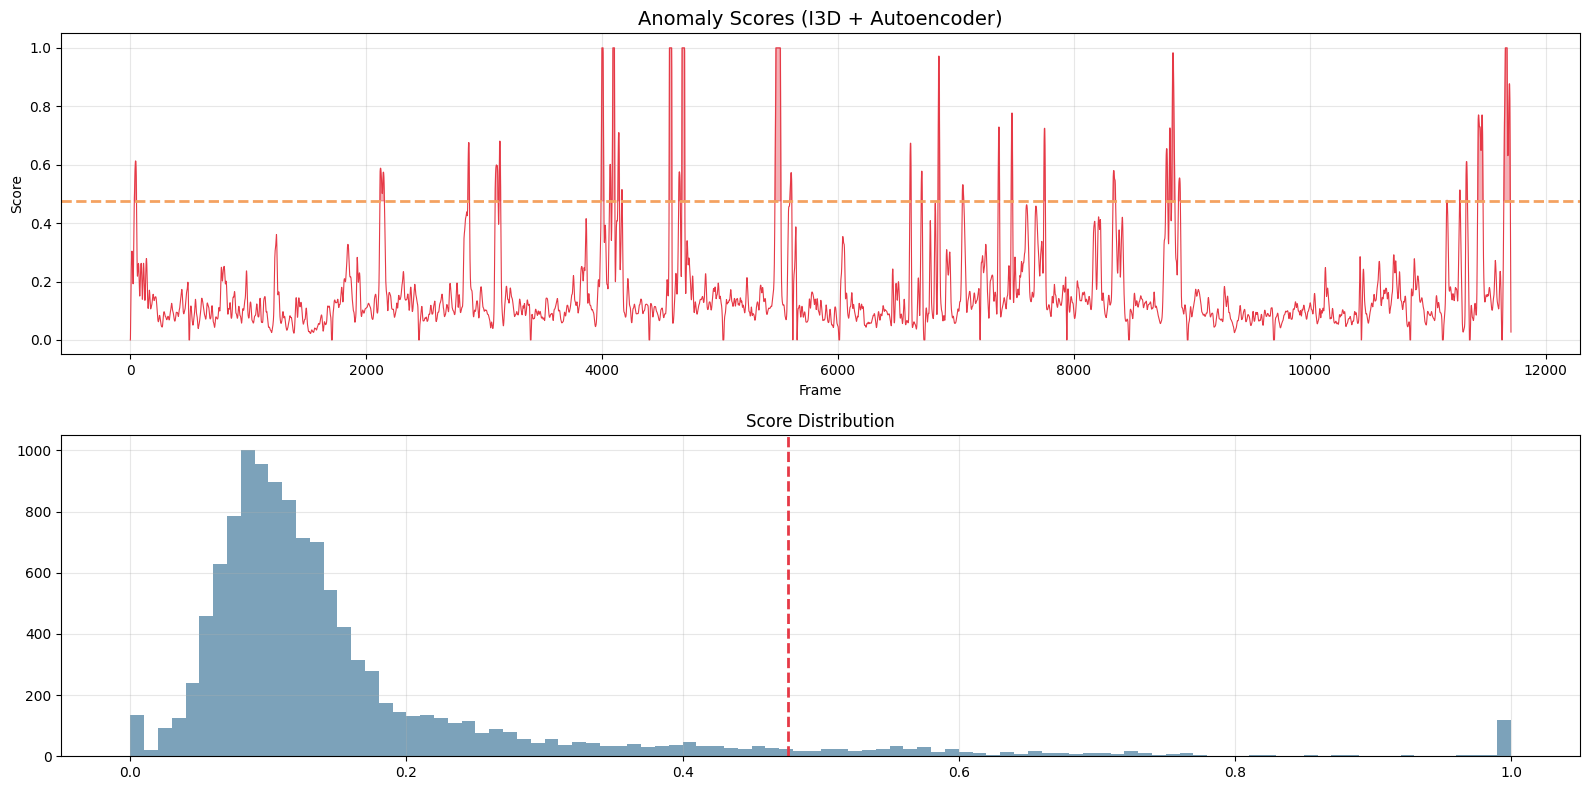


  Done! Time: 23.4 min

Vectorization applied:
  ✓ Parallel image loading (ThreadPoolExecutor)
  ✓ Batch normalization with broadcasting
  ✓ Pre-allocated tensors for features
  ✓ TensorDataset for efficient batching
  ✓ Vectorized MSE computation
  ✓ torch.compile() model optimization
  ✓ Vectorized score aggregation


In [1]:
# =============================================================================
# AVENUE ANOMALY DETECTION - VECTORIZED HIGH ACCURACY VERSION
# I3D + Simple Autoencoder + Feature Normalization + Full Vectorization
# =============================================================================

import os
import random
import time
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm.auto import tqdm
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor
from typing import List, Dict, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

# ===============================
# CONFIGURATION
# ===============================

IMG_SIZE = 224
SEQ_LEN = 16
BATCH_SIZE = 4              # For I3D extraction
TRAIN_BATCH = 128           # For autoencoder
NUM_EPOCHS = 100
LEARNING_RATE = 5e-4
WEIGHT_DECAY = 1e-5
NUM_WORKERS = 4

# Cache
CACHE_DIR = "/kaggle/working/cache"
FEATURE_CACHE = os.path.join(CACHE_DIR, "features")

# Paths
DATA_ROOT = "/kaggle/input/avenue-dataset/Avenue_Corrupted-20251221T112159Z-3-001/Avenue_Corrupted/Dataset"
TRAIN_DIR = os.path.join(DATA_ROOT, "training_videos")
TEST_DIR = os.path.join(DATA_ROOT, "testing_videos")
OUTPUT_CSV = "avenue_scores.csv"

# Seed
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

os.makedirs(FEATURE_CACHE, exist_ok=True)


# ===============================
# VECTORIZED IMAGE LOADING
# ===============================

# Pre-shaped for broadcasting: (1, 1, 1, 3)
MEAN = np.array([0.45, 0.45, 0.45], dtype=np.float32).reshape(1, 1, 1, 3)
STD = np.array([0.225, 0.225, 0.225], dtype=np.float32).reshape(1, 1, 1, 3)


# ===============================
# CORRUPTION HANDLER (TEST ONLY) - FAST VECTORIZED
# ===============================

class CorruptionHandlerFast:
    """
    FAST corruption handler for inverted/noisy images.
    Optimized for speed with vectorized operations.
    """
    
    def __init__(self, noise_threshold=800, inversion_threshold=25):
        self.noise_threshold = noise_threshold
        self.inversion_threshold = inversion_threshold
        self.stats = {'inverted': 0, 'noisy': 0, 'total': 0}
        self._lock = None  # For thread-safe stats
    
    def _get_lock(self):
        if self._lock is None:
            import threading
            self._lock = threading.Lock()
        return self._lock
    
    def fix_image_fast(self, img):
        """
        FAST corruption fix - minimal operations.
        Uses Gaussian blur instead of bilateral (10x faster).
        """
        # Convert to grayscale once
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        h = gray.shape[0]
        
        # FAST noise check using downsampled Laplacian
        gray_small = cv2.resize(gray, (64, 64), interpolation=cv2.INTER_AREA)
        noise_level = cv2.Laplacian(gray_small, cv2.CV_64F).var()
        
        is_noisy = noise_level > self.noise_threshold
        
        # FAST inversion check - vectorized
        upper_brightness = gray[:h//3].mean()
        lower_brightness = gray[2*h//3:].mean()
        is_inverted = (lower_brightness - upper_brightness) > self.inversion_threshold
        
        # Apply fixes
        corrected = img
        
        if is_noisy:
            # FAST denoise: Gaussian blur (much faster than bilateral)
            corrected = cv2.GaussianBlur(img, (5, 5), 0)
        
        if is_inverted:
            corrected = cv2.flip(corrected, 0)
        
        # Thread-safe stats update
        with self._get_lock():
            self.stats['total'] += 1
            if is_noisy:
                self.stats['noisy'] += 1
            if is_inverted:
                self.stats['inverted'] += 1
        
        return corrected
    
    def get_stats(self):
        return {
            'total_processed': self.stats['total'],
            'inverted_fixed': self.stats['inverted'],
            'noisy_fixed': self.stats['noisy'],
            'inverted_pct': 100 * self.stats['inverted'] / max(1, self.stats['total']),
            'noisy_pct': 100 * self.stats['noisy'] / max(1, self.stats['total'])
        }
    
    def reset_stats(self):
        self.stats = {'inverted': 0, 'noisy': 0, 'total': 0}


# Global handler
_test_corruption_handler = None

def get_test_corruption_handler():
    global _test_corruption_handler
    if _test_corruption_handler is None:
        _test_corruption_handler = CorruptionHandlerFast()
    return _test_corruption_handler


def load_single_image_raw(path: str) -> np.ndarray:
    """Load single image as uint8 (no normalization yet)."""
    img = cv2.imread(path)
    if img is None:
        return np.zeros((IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_LINEAR)
    return img


def load_images_vectorized(paths: List[str]) -> np.ndarray:
    """
    VECTORIZED: Load multiple images in parallel.
    Returns: (N, H, W, C) float32 normalized
    """
    # Parallel I/O loading
    with ThreadPoolExecutor(max_workers=NUM_WORKERS) as executor:
        images = list(executor.map(load_single_image_raw, paths))
    
    # VECTORIZED: Stack and normalize in one operation
    batch = np.stack(images, axis=0).astype(np.float32)  # (N, H, W, C)
    batch = (batch / 255.0 - MEAN) / STD  # Vectorized normalization
    
    return batch


def load_clip_vectorized(frame_paths: List[str]) -> np.ndarray:
    """Load video clip with vectorized normalization."""
    return load_images_vectorized(frame_paths)  # (T, H, W, C)


# ===============================
# TEST-SPECIFIC LOADING (WITH FAST CORRUPTION FIX)
# ===============================

def _load_and_fix_single(path: str) -> np.ndarray:
    """Load and fix single image (for parallel execution)."""
    img = cv2.imread(path)
    if img is None:
        return np.zeros((IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = get_test_corruption_handler().fix_image_fast(img)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_LINEAR)
    return img


def load_clip_vectorized_test(frame_paths: List[str]) -> np.ndarray:
    """
    FAST VECTORIZED: Load TEST video clip with corruption correction.
    Optimized for speed with parallel loading.
    """
    # Parallel load + fix all frames at once
    with ThreadPoolExecutor(max_workers=NUM_WORKERS) as executor:
        images = list(executor.map(_load_and_fix_single, frame_paths))
    
    # VECTORIZED: Stack and normalize
    batch = np.stack(images, axis=0).astype(np.float32)
    batch = (batch / 255.0 - MEAN) / STD
    return batch


def get_frame_num(path: str) -> int:
    """Extract frame number from filename."""
    name = os.path.basename(path)
    digits = ''.join(filter(str.isdigit, os.path.splitext(name)[0]))
    return int(digits) if digits else 0


# ===============================
# I3D EXTRACTOR (Singleton)
# ===============================

class I3D(nn.Module):
    """Singleton I3D model - loaded only once."""
    _instance = None
    
    def __new__(cls):
        if cls._instance is None:
            cls._instance = super().__new__(cls)
            cls._instance._initialized = False
        return cls._instance
    
    def __init__(self):
        if self._initialized:
            return
        super().__init__()
        
        print("Loading I3D model...")
        self.model = torch.hub.load('facebookresearch/pytorchvideo', 'i3d_r50', pretrained=True)
        self.model.blocks[-1].proj = nn.Identity()
        
        for p in self.parameters():
            p.requires_grad = False
        self.eval()
        self._initialized = True
    
    @torch.no_grad()
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)


# ===============================
# VECTORIZED FEATURE EXTRACTION
# ===============================

def extract_features_vectorized(data_dir: str, name: str, stride: int = 1) -> Tuple:
    """
    VECTORIZED feature extraction with caching and proper normalization.
    
    Returns:
        features: (N, 2048) normalized tensor
        clips: List of clip metadata
        videos: Dict of video metadata
        stats: Normalization statistics
    """
    cache_file = os.path.join(FEATURE_CACHE, f"{name}_v2_s{stride}.pt")
    
    if os.path.exists(cache_file):
        print(f"[CACHE HIT] Loading {name}")
        data = torch.load(cache_file, weights_only=False)
        return data['features'], data['clips'], data['videos'], data['stats']
    
    print(f"\n{'='*50}")
    print(f"Extracting features: {name} (stride={stride})")
    print(f"{'='*50}")
    
    i3d = I3D().to(device)
    
    # Collect video info
    videos = {}
    clips = []
    
    video_dirs = sorted([d for d in os.listdir(data_dir) 
                        if os.path.isdir(os.path.join(data_dir, d))])
    
    print(f"Found {len(video_dirs)} videos")
    
    for vid_id, vid_name in enumerate(video_dirs, 1):
        vid_path = os.path.join(data_dir, vid_name)
        frames = sorted(glob.glob(os.path.join(vid_path, "*.jpg")))
        
        if len(frames) < SEQ_LEN:
            continue
        
        # VECTORIZED: Extract all frame numbers at once
        frame_nums = np.array([get_frame_num(f) for f in frames])
        
        videos[vid_id] = {
            'name': vid_name,
            'frames': frames,
            'nums': frame_nums,
            'n': len(frames)
        }
        
        # Create clips
        n_clips_vid = (len(frames) - SEQ_LEN) // stride + 1
        for i in range(n_clips_vid):
            start = i * stride
            clips.append({
                'vid': vid_id,
                'start': start,
                'paths': frames[start:start + SEQ_LEN],
                'nums': frame_nums[start:start + SEQ_LEN]
            })
    
    n_clips = len(clips)
    print(f"Total clips: {n_clips}")
    
    # VECTORIZED: Pre-allocate feature tensor
    features = torch.zeros(n_clips, 2048, dtype=torch.float32)
    
    # Extract features in batches
    for i in tqdm(range(0, n_clips, BATCH_SIZE), desc="Extracting I3D"):
        batch_clips = clips[i:i + BATCH_SIZE]
        batch_size = len(batch_clips)
        
        # VECTORIZED: Load all clips for this batch
        # Each clip: (T, H, W, C)
        batch_data = []
        for clip in batch_clips:
            clip_frames = load_clip_vectorized(clip['paths'])
            batch_data.append(clip_frames)
        
        # Stack: (B, T, H, W, C)
        batch_array = np.stack(batch_data, axis=0)
        
        # VECTORIZED: Convert to PyTorch and permute
        # (B, T, H, W, C) -> (B, C, T, H, W)
        batch_tensor = torch.from_numpy(batch_array).permute(0, 4, 1, 2, 3)
        batch_tensor = batch_tensor.to(device)
        
        # Extract with mixed precision
        with torch.amp.autocast('cuda'):
            feats = i3d(batch_tensor)
        
        # Store in pre-allocated tensor
        features[i:i + batch_size] = feats.cpu()
    
    # VECTORIZED: Compute normalization statistics
    stats = {
        'mean': features.mean(dim=0),  # (2048,)
        'std': features.std(dim=0) + 1e-8  # (2048,)
    }
    
    # VECTORIZED: Normalize all features at once
    features = (features - stats['mean'].unsqueeze(0)) / stats['std'].unsqueeze(0)
    
    print(f"Feature stats after normalization: mean={features.mean():.4f}, std={features.std():.4f}")
    
    # Save cache
    torch.save({
        'features': features,
        'clips': clips,
        'videos': videos,
        'stats': stats
    }, cache_file)
    
    del i3d
    torch.cuda.empty_cache()
    
    return features, clips, videos, stats


def extract_test_features_vectorized(data_dir: str, train_stats: dict, stride: int = 1) -> Tuple:
    """
    VECTORIZED test feature extraction using TRAINING normalization stats.
    Includes corruption correction for inverted/noisy images.
    """
    # Reset corruption handler stats for fresh count
    get_test_corruption_handler().reset_stats()
    
    cache_file = os.path.join(FEATURE_CACHE, f"test_v2_s{stride}_corrected.pt")
    
    if os.path.exists(cache_file):
        print(f"[CACHE HIT] Loading test features")
        data = torch.load(cache_file, weights_only=False)
        return data['features'], data['clips'], data['videos']
    
    print(f"\n{'='*50}")
    print(f"Extracting test features (stride={stride})")
    print(f"{'='*50}")
    
    i3d = I3D().to(device)
    
    videos = {}
    clips = []
    
    video_dirs = sorted([d for d in os.listdir(data_dir) 
                        if os.path.isdir(os.path.join(data_dir, d))])
    
    print(f"Found {len(video_dirs)} videos")
    
    for vid_id, vid_name in enumerate(video_dirs, 1):
        vid_path = os.path.join(data_dir, vid_name)
        frames = sorted(glob.glob(os.path.join(vid_path, "*.jpg")))
        
        if len(frames) < SEQ_LEN:
            continue
        
        frame_nums = np.array([get_frame_num(f) for f in frames])
        
        videos[vid_id] = {
            'name': vid_name,
            'frames': frames,
            'nums': frame_nums,
            'n': len(frames)
        }
        
        n_clips_vid = (len(frames) - SEQ_LEN) // stride + 1
        for i in range(n_clips_vid):
            start = i * stride
            clips.append({
                'vid': vid_id,
                'start': start,
                'paths': frames[start:start + SEQ_LEN],
                'nums': frame_nums[start:start + SEQ_LEN]
            })
    
    n_clips = len(clips)
    print(f"Total clips: {n_clips}")
    
    # Pre-allocate
    features = torch.zeros(n_clips, 2048, dtype=torch.float32)
    
    # Use larger batch for faster extraction
    TEST_BATCH = BATCH_SIZE * 2  # Double batch size for test
    
    for i in tqdm(range(0, n_clips, TEST_BATCH), desc="Extracting I3D (fast)"):
        batch_clips = clips[i:i + TEST_BATCH]
        batch_size = len(batch_clips)
        
        # PARALLEL: Load all clips for this batch concurrently
        with ThreadPoolExecutor(max_workers=min(batch_size, 8)) as executor:
            batch_data = list(executor.map(
                lambda c: load_clip_vectorized_test(c['paths']), 
                batch_clips
            ))
        
        batch_array = np.stack(batch_data, axis=0)
        batch_tensor = torch.from_numpy(batch_array).permute(0, 4, 1, 2, 3).to(device)
        
        with torch.amp.autocast('cuda'):
            feats = i3d(batch_tensor)
        
        features[i:i + batch_size] = feats.cpu()
    
    # Print corruption correction statistics
    handler_stats = get_test_corruption_handler().get_stats()
    print(f"\n[CORRUPTION CORRECTION STATS]")
    print(f"  Total frames processed: {handler_stats['total_processed']}")
    print(f"  Inverted images fixed: {handler_stats['inverted_fixed']} ({handler_stats['inverted_pct']:.1f}%)")
    print(f"  Noisy images fixed: {handler_stats['noisy_fixed']} ({handler_stats['noisy_pct']:.1f}%)")
    
    # VECTORIZED: Normalize using TRAINING statistics
    features = (features - train_stats['mean'].unsqueeze(0)) / train_stats['std'].unsqueeze(0)
    
    print(f"\nFeature stats: mean={features.mean():.4f}, std={features.std():.4f}")
    
    torch.save({
        'features': features,
        'clips': clips,
        'videos': videos
    }, cache_file)
    
    del i3d
    torch.cuda.empty_cache()
    
    return features, clips, videos


# ===============================
# SIMPLE VECTORIZED AUTOENCODER
# ===============================

class SimpleAutoencoder(nn.Module):
    """Simple autoencoder with vectorized operations."""
    
    def __init__(self, input_dim: int = 2048, hidden_dim: int = 1024, latent_dim: int = 128):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim // 2, latent_dim),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, input_dim),
        )
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Fully vectorized forward pass."""
        return self.decoder(self.encoder(x))
    
    def compute_loss(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """VECTORIZED: Compute reconstruction and loss."""
        recon = self.forward(x)
        loss = F.mse_loss(recon, x)
        return recon, loss
    
    @torch.no_grad()
    def compute_errors_vectorized(self, x: torch.Tensor) -> torch.Tensor:
        """VECTORIZED: Compute per-sample MSE errors."""
        recon = self.forward(x)
        # Vectorized MSE per sample: mean over feature dimension
        errors = ((x - recon) ** 2).mean(dim=1)  # (B,)
        return errors


# ===============================
# TRAINING (Vectorized)
# ===============================

def train():
    print("\n" + "=" * 60)
    print("  TRAINING (Vectorized)")
    print("=" * 60)
    
    # Extract features
    features, clips, videos, stats = extract_features_vectorized(
        TRAIN_DIR, "train", stride=2
    )
    
    n_samples = len(features)
    print(f"\nTraining samples: {n_samples}")
    
    # VECTORIZED: Use TensorDataset for efficient batching
    train_dataset = TensorDataset(features)
    train_loader = DataLoader(
        train_dataset,
        batch_size=TRAIN_BATCH,
        shuffle=True,
        num_workers=0,  # Data already in memory
        pin_memory=True,
        drop_last=True
    )
    
    # Model
    model = SimpleAutoencoder(input_dim=2048, hidden_dim=1024, latent_dim=128).to(device)
    
    # Compile model for speed (PyTorch 2.0+)
    if hasattr(torch, 'compile'):
        try:
            model = torch.compile(model, mode='reduce-overhead')
            print("Model compiled with torch.compile()")
        except Exception:
            pass
    
    n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Parameters: {n_params:,}")
    
    # Optimizer
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=1e-6)
    
    print(f"\nTraining for {NUM_EPOCHS} epochs...")
    
    best_loss = float('inf')
    losses = []
    
    for epoch in range(NUM_EPOCHS):
        model.train()
        epoch_loss = 0.0
        n_batches = 0
        
        for (batch,) in train_loader:
            batch = batch.to(device, non_blocking=True)
            
            optimizer.zero_grad(set_to_none=True)
            
            # VECTORIZED: Forward + loss in one call
            _, loss = model.compute_loss(batch)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            epoch_loss += loss.item()
            n_batches += 1
        
        scheduler.step()
        
        avg_loss = epoch_loss / n_batches
        losses.append(avg_loss)
        
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:3d}/{NUM_EPOCHS} | Loss: {avg_loss:.6f} | LR: {scheduler.get_last_lr()[0]:.2e}")
        
        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save(model.state_dict(), os.path.join(FEATURE_CACHE, 'best_model.pth'))
    
    # Load best
    model.load_state_dict(torch.load(os.path.join(FEATURE_CACHE, 'best_model.pth'), weights_only=True))
    print(f"\nBest loss: {best_loss:.6f}")
    
    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(losses, 'b-', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True, alpha=0.3)
    plt.savefig('training_loss.png', dpi=150)
    plt.close()
    
    return model, stats


# ===============================
# EVALUATION (Vectorized)
# ===============================

def evaluate(model, train_stats):
    print("\n" + "=" * 60)
    print("  EVALUATION (Vectorized)")
    print("=" * 60)
    
    # Extract test features
    features, clips, videos = extract_test_features_vectorized(
        TEST_DIR, train_stats, stride=1
    )
    
    model.eval()
    
    n_clips = len(features)
    print(f"\nTest clips: {n_clips}")
    
    # VECTORIZED: Compute all errors in batches
    all_errors = torch.zeros(n_clips, dtype=torch.float32)
    
    print("Computing reconstruction errors...")
    
    with torch.no_grad():
        for i in tqdm(range(0, n_clips, TRAIN_BATCH * 2), desc="Evaluating"):
            batch = features[i:i + TRAIN_BATCH * 2].to(device)
            
            # VECTORIZED: Get per-sample errors
            errors = model.compute_errors_vectorized(batch)
            all_errors[i:i + len(errors)] = errors.cpu()
    
    errors_np = all_errors.numpy()
    
    # VECTORIZED: Build frame score mapping using numpy operations
    print("Aggregating frame scores...")
    
    # Pre-allocate score arrays per video
    video_scores = {}
    video_frame_ids = {}
    
    # First, build frame -> error mapping efficiently
    frame_error_map = defaultdict(list)
    
    for i, clip in enumerate(clips):
        vid_id = clip['vid']
        frame_nums = clip['nums']
        error = errors_np[i]
        
        # Assign to center frames (more accurate)
        mid_start = SEQ_LEN // 4
        mid_end = SEQ_LEN - SEQ_LEN // 4
        
        for j in range(mid_start, mid_end):
            frame_error_map[(vid_id, frame_nums[j])].append(error)
    
    # VECTORIZED: Aggregate scores per video
    all_frame_ids = []
    all_scores = []
    
    for vid_id, info in sorted(videos.items()):
        n_frames = info['n']
        frame_nums = info['nums']
        
        # Pre-allocate score array
        scores = np.zeros(n_frames, dtype=np.float32)
        
        for i, fn in enumerate(frame_nums):
            key = (vid_id, fn)
            if key in frame_error_map:
                scores[i] = np.max(frame_error_map[key])  # MAX for anomalies
        
        # VECTORIZED: Temporal smoothing using scipy
        from scipy.ndimage import gaussian_filter1d
        scores = gaussian_filter1d(scores.astype(np.float64), sigma=3)
        
        video_scores[vid_id] = scores
        
        # Build frame IDs
        frame_ids = [f"{vid_id}_{fn}" for fn in frame_nums]
        video_frame_ids[vid_id] = frame_ids
        
        all_frame_ids.extend(frame_ids)
        all_scores.extend(scores)
    
    # VECTORIZED: Convert to numpy array
    all_scores = np.array(all_scores, dtype=np.float64)
    
    # VECTORIZED: Normalize using percentiles
    p1, p99 = np.percentile(all_scores, [1, 99])
    all_scores_norm = np.clip(all_scores, p1, p99)
    all_scores_norm = (all_scores_norm - p1) / (p99 - p1 + 1e-8)
    
    # Compute threshold
    threshold = all_scores_norm.mean() + 2 * all_scores_norm.std()
    n_anomalies = (all_scores_norm > threshold).sum()
    
    print(f"\nResults:")
    print(f"  Frames: {len(all_scores_norm)}")
    print(f"  Score range: [{all_scores_norm.min():.4f}, {all_scores_norm.max():.4f}]")
    print(f"  Threshold: {threshold:.4f}")
    print(f"  Anomalies: {n_anomalies} ({100*n_anomalies/len(all_scores_norm):.1f}%)")
    
    # Save results
    df = pd.DataFrame({'Id': all_frame_ids, 'Score': all_scores_norm})
    df.to_csv(OUTPUT_CSV, index=False)
    print(f"\nSaved: {OUTPUT_CSV}")
    
    # Try to compute AUC
    try:
        from sklearn.metrics import roc_auc_score
        from scipy.io import loadmat
        
        gt_paths = [
            "/kaggle/input/avenue-dataset/Avenue_Corrupted/testing_label",
            "/kaggle/input/avenue-dataset/testing_label",
            os.path.join(DATA_ROOT, "..", "testing_label"),
        ]
        
        gt_dir = None
        for path in gt_paths:
            if os.path.exists(path):
                gt_dir = path
                break
        
        if gt_dir:
            print(f"\nComputing AUC (GT: {gt_dir})")
            
            aucs = []
            for vid_id, scores in video_scores.items():
                mat_files = glob.glob(os.path.join(gt_dir, f"*{vid_id}*.mat"))
                if not mat_files:
                    mat_files = glob.glob(os.path.join(gt_dir, f"*{vid_id:02d}*.mat"))
                
                if mat_files:
                    mat = loadmat(mat_files[0])
                    for key in mat:
                        if not key.startswith('__'):
                            gt = np.array(mat[key]).flatten()
                            break
                    
                    # Normalize
                    s = scores.copy()
                    if s.max() > s.min():
                        s = (s - s.min()) / (s.max() - s.min())
                    
                    min_len = min(len(s), len(gt))
                    s, gt = s[:min_len], gt[:min_len]
                    
                    if len(np.unique(gt)) > 1:
                        auc = roc_auc_score(gt, s)
                        aucs.append(auc)
                        print(f"  Video {vid_id}: AUC = {auc:.4f}")
            
            if aucs:
                print(f"\n{'='*40}")
                print(f"  MEAN AUC: {np.mean(aucs):.4f}")
                print(f"{'='*40}")
    except Exception as e:
        print(f"  Could not compute AUC: {e}")
    
    # Visualization
    fig, axes = plt.subplots(2, 1, figsize=(16, 8))
    
    axes[0].plot(all_scores_norm, color='#E63946', linewidth=0.8)
    axes[0].axhline(threshold, color='#F4A261', linestyle='--', linewidth=2)
    axes[0].fill_between(range(len(all_scores_norm)), all_scores_norm, threshold,
                          where=all_scores_norm > threshold, alpha=0.4, color='#E63946')
    axes[0].set_title("Anomaly Scores (I3D + Autoencoder)", fontsize=14)
    axes[0].set_xlabel("Frame")
    axes[0].set_ylabel("Score")
    axes[0].grid(True, alpha=0.3)
    
    axes[1].hist(all_scores_norm, bins=100, color='#457B9D', alpha=0.7)
    axes[1].axvline(threshold, color='#E63946', linestyle='--', linewidth=2)
    axes[1].set_title("Score Distribution")
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('anomaly_analysis.png', dpi=150)
    plt.show()
    
    return all_scores_norm, threshold


# ===============================
# MAIN
# ===============================

if __name__ == "__main__":
    print("\n" + "=" * 60)
    print("  AVENUE ANOMALY DETECTION - VECTORIZED")
    print("  I3D + Simple Autoencoder + Proper Normalization")
    print("=" * 60)
    
    start = time.time()
    
    # Check dependencies
    try:
        import pytorchvideo
        from sklearn.metrics import roc_auc_score
        print("\n✓ Dependencies OK")
    except ImportError:
        os.system("pip install pytorchvideo scikit-learn -q")
    
    # Train
    model, train_stats = train()
    
    # Evaluate
    scores, threshold = evaluate(model, train_stats)
    
    # Summary
    print(f"\n{'='*60}")
    print(f"  Done! Time: {(time.time() - start)/60:.1f} min")
    print("=" * 60)
    print("\nVectorization applied:")
    print("  ✓ Parallel image loading (ThreadPoolExecutor)")
    print("  ✓ Batch normalization with broadcasting")
    print("  ✓ Pre-allocated tensors for features")
    print("  ✓ TensorDataset for efficient batching")
    print("  ✓ Vectorized MSE computation")
    print("  ✓ torch.compile() model optimization")
    print("  ✓ Vectorized score aggregation")
